# 0.0 IMPORTS

In [2]:
import pandas as pd
import numpy as np
import inflection
import os
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
import xgboost as xgb

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from boruta import BorutaPy
from datetime import datetime, timedelta
from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn import ensemble as en
from sklearn import metrics as mt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import svm

warnings.filterwarnings('ignore')

## 0.1 Loading Data

In [42]:
path = 'C:/Users/edils/repos/leilao_fechamento/data/test_petr/'

In [43]:
# df_raw_list = []

# for file in os.listdir(path):
#     if file.endswith('.csv'):
#         filename_path = os.path.join(path, file)
#         df = pd.read_csv(filename_path, encoding='iso-8859-1', sep=';')
#         df_raw_list.append(df)

In [44]:
# df_raw = pd.concat(df_raw_list, axis=0)

In [45]:
df_raw = pd.read_csv(path + 'PETR4_B_0_5min.csv', encoding='iso-8859-1', sep=';')

In [46]:
df_raw.head()

,Ativo,Data,Hora,Abertura,Máximo,Mínimo,Fechamento,Volume,Quantidade
0,PETR4,26/05/2023,17:30:00,"26,79","26,80","26,76","26,79","1.518.499,00",56.700
1,PETR4,26/05/2023,16:50:00,"26,76","26,80","26,74","26,80","86.912.867,00",3.244.400
2,PETR4,26/05/2023,16:45:00,"26,77","26,80","26,74","26,77","18.082.061,00",675.700
3,PETR4,26/05/2023,16:40:00,"26,80","26,82","26,75","26,77","18.316.014,00",683.700
4,PETR4,26/05/2023,16:35:00,"26,81","26,83","26,78","26,81","23.448.773,00",874.900


In [47]:
df_raw.dtypes

Ativo         object
Data          object
Hora          object
Abertura      object
Máximo        object
Mínimo        object
Fechamento    object
Volume        object
Quantidade    object
dtype: object

## 0.2 Helper Functions

In [48]:
def data_types(df1):
    #abertura
    df1['abertura'] = df1['abertura'].apply(lambda x: x.replace(',','.'))
    df1['abertura'] = df1['abertura'].astype(float)

    #maximo
    df1['maximo'] = df1['maximo'].apply(lambda x: x.replace(',','.'))
    df1['maximo'] = df1['maximo'].astype(float)

    #minimo
    df1['minimo'] = df1['minimo'].apply(lambda x: x.replace(',','.'))
    df1['minimo'] = df1['minimo'].astype(float)

    #fechamento
    df1['fechamento'] = df1['fechamento'].apply(lambda x: x.replace(',','.'))
    df1['fechamento'] = df1['fechamento'].astype(float)

    #volume
    df1['volume'] = df1['volume'].apply(lambda x: x.replace(".", "").replace(",", "."))
    df1['volume'] = df1['volume'].astype(float)

    #quantidade
    df1['quantidade'] = df1['quantidade'].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
    df1['quantidade'] = df1['quantidade'].apply(lambda x: float(x))

    #data
    df1['data'] = df1['data'].apply(lambda x: x.replace('/','-'))
    df1['data'] = df1['data'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df1['data'] = pd.to_datetime(df1['data'], format='%d-%m-%Y')
    df1['hora'] = df1['hora'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
    
    return df1

def rename_columns(df1):
    cols_old = df1.columns
    cols_new = cols_old.map(lambda x: inflection.underscore(x))
    df1.columns = cols_new
    df1 = df1.rename(columns={'máximo': 'maximo', 'mínimo':'minimo'})
    
    return df1

def changing_time(df1):
    #Horário de verão 2023-03-13
    data_verao = pd.to_datetime('2023-03-13')
    df1.loc[df1['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)
    hora_leilao = (df1['hora'].dt.hour >= 16) & (df1['hora'].dt.hour < 18) 
    df1 = df1.loc[hora_leilao,:]
    return df1

def clean_futuros(df_win):
    cols_old = df_win.columns
    cols_new = cols_old.map(lambda x: inflection.underscore(x))
    df_win.columns = cols_new
    df_win = df_win.rename(columns={'máximo': 'maximo', 'mínimo':'minimo'})

    df_win['abertura'] = df_win['abertura'].astype(float)

    #maximo

    df_win['maximo'] = df_win['maximo'].astype(float)

    #minimo

    df_win['minimo'] = df_win['minimo'].astype(float)

    #fechamento

    df_win['fechamento'] = df_win['fechamento'].astype(float)

    #volume
    df_win['volume'] = df_win['volume'].apply(lambda x: x.replace(".", "").replace(",", "."))
    df_win['volume'] = df_win['volume'].astype(float)

    #quantidade
    df_win['quantidade'] = df_win['quantidade'].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
    df_win['quantidade'] = df_win['quantidade'].apply(lambda x: float(x))

    #data
    df_win['data'] = df_win['data'].apply(lambda x: x.replace('/','-'))
    df_win['data'] = df_win['data'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df_win['data'] = pd.to_datetime(df_win['data'], format='%d-%m-%Y')
    df_win['hora'] = df_win['hora'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
    df_win['variacao'] = (df_win['fechamento'] - df_win['abertura']) / df_win['abertura']
    
    #Horário de verão 2023-03-13
    data_verao = pd.to_datetime('2023-03-13')
    df_win.loc[df_win['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)
    
    hora_leilao = (df_win['hora'].dt.hour >= 16) & (df_win['hora'].dt.hour < 18) 
    df_win = df_win.loc[hora_leilao,:]
    
    df_win['variacao'] = (df_win['fechamento'] - df_win['abertura']) / df_win['abertura']
    
    return df_win

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mt.mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))
   
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE':mape,
                        'RMSE':rmse},index=[0])
    

# 1.0 DATA DESCRIPTION

In [70]:
df1 = df_raw.copy()

In [71]:
df1

,Ativo,Data,Hora,Abertura,Máximo,Mínimo,Fechamento,Volume,Quantidade
0,PETR4,26/05/2023,17:30:00,"26,79","26,80","26,76","26,79","1.518.499,00",56.700
1,PETR4,26/05/2023,16:50:00,"26,76","26,80","26,74","26,80","86.912.867,00",3.244.400
2,PETR4,26/05/2023,16:45:00,"26,77","26,80","26,74","26,77","18.082.061,00",675.700
3,PETR4,26/05/2023,16:40:00,"26,80","26,82","26,75","26,77","18.316.014,00",683.700
4,PETR4,26/05/2023,16:35:00,"26,81","26,83","26,78","26,81","23.448.773,00",874.900
...,...,...,...,...,...,...,...,...,...
14332,PETR4,30/09/2022,15:30:00,"23,39","23,46","23,39","23,46","62.166.319,00",2.077.100
14333,PETR4,30/09/2022,15:25:00,"23,45","23,49","23,38","23,39","28.148.235,00",940.600
14334,PETR4,30/09/2022,15:20:00,"23,56","23,58","23,41","23,45","47.382.040,00",1.579.800
14335,PETR4,30/09/2022,15:15:00,"23,50","23,61","23,50","23,56","25.101.653,00",833.800


## 1.1 Rename Columns

In [72]:
df1 = rename_columns(df1)

## 1.2 Data Types

In [73]:
df1.dtypes

ativo         object
data          object
hora          object
abertura      object
maximo        object
minimo        object
fechamento    object
volume        object
quantidade    object
dtype: object

In [74]:
df1 = data_types(df1)

## 1.3 Check NA

In [75]:
df1.isna().sum()

ativo         0
data          0
hora          0
abertura      0
maximo        0
minimo        0
fechamento    0
volume        0
quantidade    0
dtype: int64

## 1.4 Data Shape

In [76]:
df1.shape

(14337, 9)

## 1.5 Changing Time

In [77]:
df1 = changing_time(df1)

## 1.6 Create Response Variable

In [78]:
df1['variacao'] = (df1['fechamento'] - df1['abertura']) / df1['abertura']

In [79]:
df1

,ativo,data,hora,abertura,maximo,minimo,fechamento,volume,quantidade,variacao
1,PETR4,2023-05-26,1900-01-01 17:50:00,26.76,26.80,26.74,26.80,86912867.0,3244400.0,0.001495
2,PETR4,2023-05-26,1900-01-01 17:45:00,26.77,26.80,26.74,26.77,18082061.0,675700.0,0.000000
3,PETR4,2023-05-26,1900-01-01 17:40:00,26.80,26.82,26.75,26.77,18316014.0,683700.0,-0.001119
4,PETR4,2023-05-26,1900-01-01 17:35:00,26.81,26.83,26.78,26.81,23448773.0,874900.0,0.000000
5,PETR4,2023-05-26,1900-01-01 17:30:00,26.82,26.83,26.80,26.82,6016491.0,224400.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
14322,PETR4,2022-09-30,1900-01-01 16:20:00,23.35,23.46,23.35,23.44,15120624.0,505800.0,0.003854
14323,PETR4,2022-09-30,1900-01-01 16:15:00,23.33,23.42,23.31,23.35,24243153.0,812400.0,0.000857
14324,PETR4,2022-09-30,1900-01-01 16:10:00,23.35,23.35,23.31,23.34,14726478.0,494100.0,-0.000428
14325,PETR4,2022-09-30,1900-01-01 16:05:00,23.38,23.46,23.34,23.35,22449454.0,751200.0,-0.001283


In [59]:
df1 = df1.drop(['abertura', 'fechamento'], axis=1)

## 1.7 Split Train Test

In [19]:
# df_splitted = df1.drop('variacao', axis=1).copy()
# y_splitted = df1['variacao'].copy()

In [20]:
# df1_splitted, X_test, y1_splitted, y_test = ms.train_test_split(df_splitted, y_splitted, test_size=0.25, random_state=0)

In [21]:
# df1 = df1_splitted.copy()
# df1['variacao'] = y1_splitted.copy()

# 2.0 Feature Engineering

In [80]:
df2 = df1.copy()

In [81]:
df2.head()

,ativo,data,hora,abertura,maximo,minimo,fechamento,volume,quantidade,variacao
1,PETR4,2023-05-26,1900-01-01 17:50:00,26.76,26.80,26.74,26.80,86912867.0,3244400.0,0.001495
2,PETR4,2023-05-26,1900-01-01 17:45:00,26.77,26.80,26.74,26.77,18082061.0,675700.0,0.000000
3,PETR4,2023-05-26,1900-01-01 17:40:00,26.80,26.82,26.75,26.77,18316014.0,683700.0,-0.001119
4,PETR4,2023-05-26,1900-01-01 17:35:00,26.81,26.83,26.78,26.81,23448773.0,874900.0,0.000000
5,PETR4,2023-05-26,1900-01-01 17:30:00,26.82,26.83,26.80,26.82,6016491.0,224400.0,0.000000


In [82]:
#create futures variation
df_win = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/test_petr/WINFUT_F_0_5min.csv', encoding='iso-8859-1', sep=';')
# df_dol = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/futuros/WINFUT_F_0_5min.csv', encoding='iso-8859-1', sep=';')
# df_sp = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/futuros/WINFUT_F_0_5min.csv', encoding='iso-8859-1', sep=';')

df_win = clean_futuros(df_win)
# df_dol = clean_futuros(df_dol)
# df_sp = clean_futuros(df_sp)

In [83]:
df2 = pd.merge(df2, df_win[['data','hora','variacao']], on=['data','hora'], how='left')
df2 = df2.rename(columns={'variacao_x':'variacao', 'variacao_y':'variacao_win'})


In [84]:
df2 = df2.dropna()

In [85]:
df2 = df2.sort_values(by='data')

In [86]:
data_test = pd.to_datetime('2023-05-19')
X_test = df2.loc[df2['data'] > data_test,:]
X_train = df2.loc[df2['data'] <= data_test,:]

In [87]:
X_test.to_csv('X_test.csv', index=False)
X_train.to_csv('X_train.csv', index=False)

# 3.0 EDA

In [132]:
df3 = df2.copy()

In [133]:
numerical_attributes = df3.select_dtypes(include=['float64','datetime64[ns]'])

In [134]:
stats = numerical_attributes.agg(['min','max', lambda x: max(x)-min(x),'mean','std','skew', 'kurtosis']).T

In [135]:
stats

,min,max,<lambda>,mean,std,skew,kurtosis
data,2023-01-06 00:00:00,2023-05-19 00:00:00,133 days 00:00:00,2023-03-13 06:49:56.531791872,39 days 01:59:03.450908081,NaN,NaN
hora,1900-01-01 16:00:00,1900-01-01 17:50:00,0 days 01:50:00,1900-01-01 16:54:51.618497280,0 days 00:33:12.897528707,NaN,NaN
maximo,20.24,26.6,6.36,22.899995,1.400882,0.284141,-0.224456
minimo,20.14,26.53,6.39,22.839769,1.397842,0.281944,-0.235219
volume,1339742.0,926735952.0,925396210.0,23100857.407033,41069722.944316,8.837302,137.947333
quantidade,55300.0,39435100.0,39379800.0,917241.425819,1643637.131152,9.594356,167.012159
variacao,-0.016178,0.013732,0.02991,-0.000014,0.001784,0.007266,7.72577
variacao_win,-0.007396,0.005519,0.012915,-0.000002,0.00092,-0.01544,5.160853


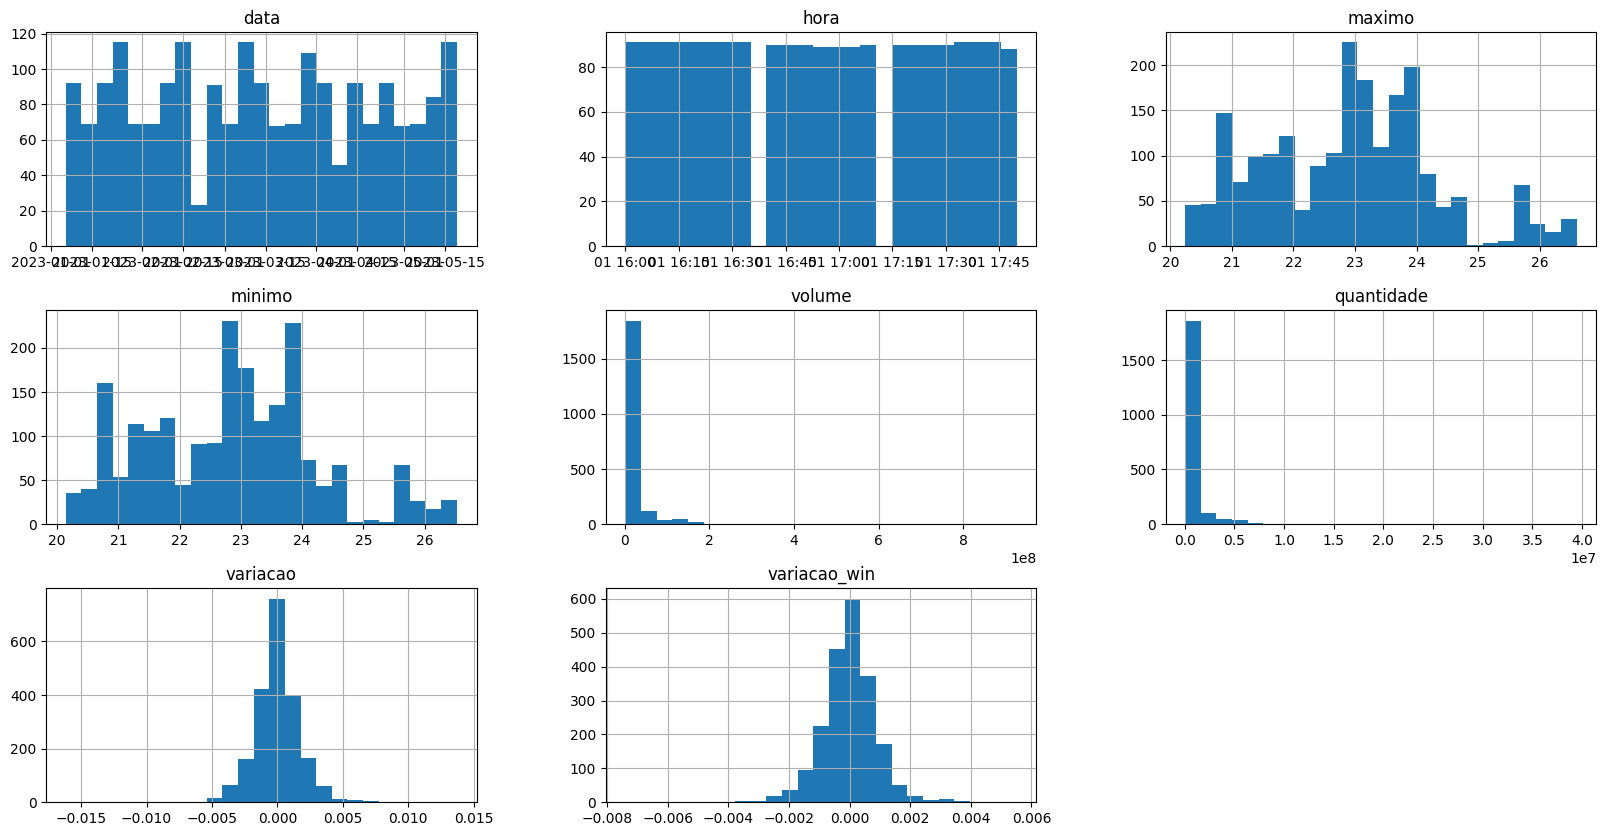

In [136]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
numerical_attributes.hist(ax = ax, bins=25);

<Axes: >

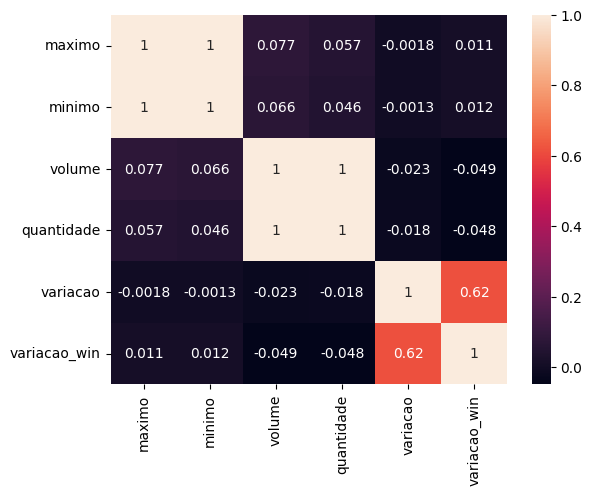

In [137]:
sns.heatmap(numerical_attributes.corr(method='pearson'), annot=True)

# 4.0 Data Preparation

In [138]:
df4 = df3.copy()

In [139]:
df4.head()

,ativo,data,hora,maximo,minimo,volume,quantidade,variacao,variacao_win
0,PETR4,2023-05-19,1900-01-01 17:50:00,25.94,25.87,497227027.0,19183700.0,0.001933,-0.000313
1,PETR4,2023-05-19,1900-01-01 17:45:00,25.92,25.82,33582703.0,1298000.0,0.000774,0.000269
2,PETR4,2023-05-19,1900-01-01 17:40:00,25.87,25.79,24891664.0,963900.0,0.000387,0.000807
3,PETR4,2023-05-19,1900-01-01 17:35:00,25.82,25.75,18727949.0,726200.0,0.001552,0.000673
4,PETR4,2023-05-19,1900-01-01 17:30:00,25.79,25.71,12525794.0,486400.0,0.001554,0.000404


## 4.1 Rescalling 

In [140]:
ss = StandardScaler()
mms = MinMaxScaler()

#Poisson -> abertura, maximo, minimo fechamento Usar 
df4['maximo'] = mms.fit_transform(df4['maximo'].values.reshape(-1,1))
df4['minimo'] = mms.fit_transform(df4['minimo'].values.reshape(-1,1))
df4['volume'] = mms.fit_transform(df4['volume'].values.reshape(-1,1))
df4['quantidade'] = mms.fit_transform(df4['quantidade'].values.reshape(-1,1))
df4['variacao'] = mms.fit_transform(df4['variacao'].values.reshape(-1,1))
df4['variacao_win'] = mms.fit_transform(df4['variacao_win'].values.reshape(-1,1))

In [141]:
numerical_attributes_transformed = df4.select_dtypes(include='float64')

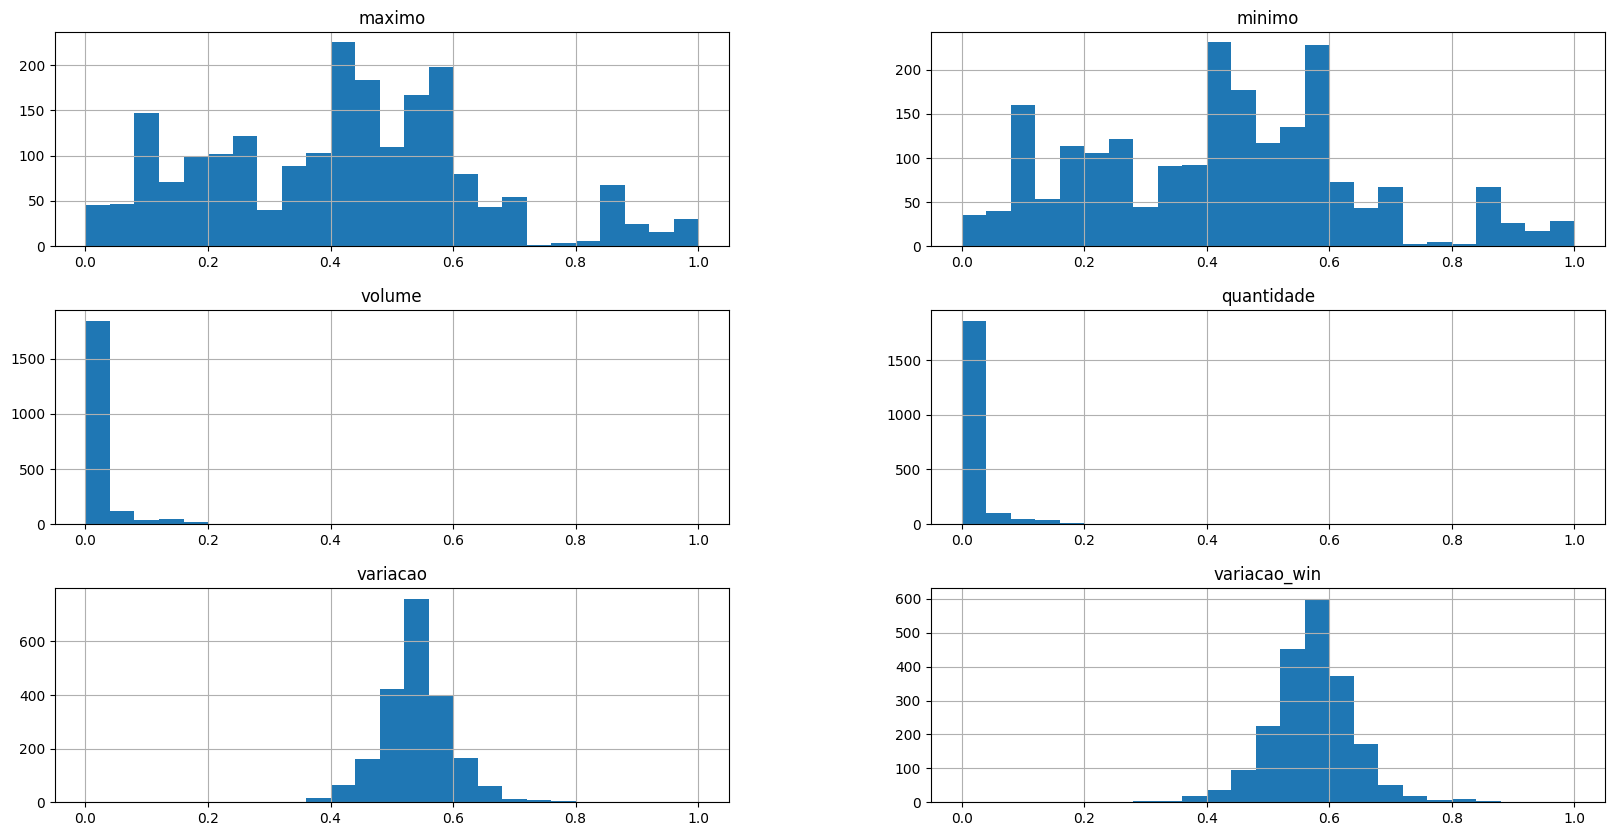

In [142]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
numerical_attributes_transformed.hist(ax = ax, bins=25);

## 4.2 Nature Transformation

In [143]:
df4['data_sin'] = df4['data'].apply(lambda x: np.sin((x.day * (2. * np.pi/21)) + (x.month * (2. * np.pi/12))))
df4['data_cos'] = df4['data'].apply(lambda x: np.cos((x.day * (2. * np.pi/21)) + (x.month * (2. * np.pi/12))))

df4['hora_sin'] = df4['hora'].apply(lambda x: np.sin((x.hour * (2. * np.pi/24)) + (x.minute * (2.*np.pi/60))))
df4['hora_cos'] = df4['hora'].apply(lambda x: np.cos((x.hour * (2. * np.pi/24)) + (x.minute * (2.*np.pi/60))))


## 4.3 Encoding

In [144]:
#Frequency encoding no ativo
fe_ativo = df4['ativo'].value_counts(normalize=True)
df4['ativo'] = df4['ativo'].map(fe_ativo)

## 4.4 Split train Validation

In [145]:
X = df4.drop('variacao', axis=1).copy()
y = df4['variacao']

In [146]:
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=0)

# 5.0 Feature Selection

## 5.1 Boruta

In [147]:
#Retirar datetime para usra no boruta
x_train_boruta = X_train.drop(columns=(['data','hora'])).copy()

In [148]:
rf = en.RandomForestRegressor(n_jobs=-1)

In [149]:
x_train_n = x_train_boruta.values
y_train_n = y_train.values
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	7


In [150]:
cols_boruta = boruta.support_.tolist()

In [151]:
x_train_selected_boruta = x_train_boruta.loc[:,cols_boruta].columns.tolist()

In [152]:
x_train_selected_boruta

['volume', 'quantidade', 'variacao_win']

## 5.2 Extratree Regressor

In [153]:
et = en.RandomForestRegressor(n_jobs=-1)

In [154]:
et.fit(x_train_n, y_train_n)

RandomForestRegressor(n_jobs=-1)

In [155]:
importances = et.feature_importances_
features = {}

for i in range(len(x_train_boruta.columns)):
    features[x_train_boruta.columns[i]] = importances[i]
    
features = pd.DataFrame(features, index=[0])    
features = features.melt(var_name='Features', value_name='Ranking')
features.sort_values(ascending=False, by='Ranking')

,Features,Ranking
5,variacao_win,0.482872
4,quantidade,0.114056
3,volume,0.112024
7,data_cos,0.060873
2,minimo,0.049812
6,data_sin,0.048996
1,maximo,0.046170
8,hora_sin,0.044452
9,hora_cos,0.040744
0,ativo,0.000000


In [156]:
cols_selected = {'volume','quantidade','variacao_win'}

# 6.0 Machine Learning

In [157]:
x_train = X_train.loc[:,cols_selected]
x_val = X_val.loc[:,cols_selected]

## 6.1 Average Model

In [60]:
aux1 = x_train.copy()
aux1['ativo'] = X_train['ativo'].copy()
aux1['variacao'] = y_train.copy()

#prediction
media_aux1 = aux1.loc[:,['ativo','variacao']].groupby('ativo').mean().reset_index().rename(columns={'variacao':'prediction'})
aux1 = pd.merge(aux1, media_aux1, how='left', on='ativo')
yhat_baseline = aux1['prediction']

#performance
metrics_avg = ml_error( 'Average Model', y_train, yhat_baseline )


## 6.2 Linear Regression

In [61]:
lr = LinearRegression()

lr.fit(x_train, y_train)

yhat_lr = lr.predict(x_val)

In [62]:
metrics_lr = ml_error('Linear Regression', y_val, yhat_lr)

## 6.3 Linear Regression LASSO

In [63]:
lasso = Lasso(alpha=0.01)

lasso.fit(x_train, y_train)

yhat_lasso = lasso.predict(x_val)

In [64]:
metrics_lasso = ml_error('Lasso', y_val, yhat_lasso)

## 6.4 Random Forest

In [65]:
rf = en.RandomForestRegressor(n_jobs=-1)

rf.fit(x_train, y_train)

yhat_rf = rf.predict(x_val)

In [66]:
metrics_rf = ml_error('Random Forest', y_val, yhat_rf )

##  6.5 XGBoost

In [67]:
xgb_model = xgb.XGBRegressor()

xgb_model.fit(x_train, y_train)

yhat_xgb = xgb_model.predict(x_val)


In [68]:
metrics_xgb = ml_error('XGBoost', y_val, yhat_xgb)

## 6.6 SVM

In [69]:
model_svm = svm.LinearSVR()

model_svm.fit(x_train, y_train)

yhat_svm = model_svm.predict(x_val)

In [70]:
metrics_svm = ml_error('SVM', y_val, yhat_svm)

## 6.7 LSTM

In [158]:
scaled_data = x_train.copy()
scaled_data['variacao'] = y_train.copy()

In [159]:
scaled_training_data = scaled_data.values

In [180]:
scaled_data

,volume,quantidade,variacao_win,variacao
15,0.084356,0.076684,0.499944,0.515031
206,0.008283,0.007923,0.648397,0.581821
1129,0.003308,0.003019,0.550727,0.540899
1185,0.038930,0.035612,0.602294,0.599502
1788,0.041063,0.036051,0.633917,0.554970
...,...,...,...,...
1033,0.004946,0.004845,0.572682,0.525305
1731,0.132788,0.118965,0.568779,0.469490
763,0.010999,0.010861,0.613744,0.556625
835,0.004830,0.004954,0.623555,0.557073


In [160]:
n_steps = 60
X_train_lstm = []
y_train_lstm = []

for i in range(n_steps, len(scaled_training_data)):
    X_train_lstm.append(scaled_training_data[i-n_steps:i])
    y_train_lstm.append(scaled_training_data[i, -1])
    
X_train_lstm = np.array(X_train_lstm)
y_train_lstm = np.array(y_train_lstm)    

In [161]:
X_train_lstm.shape

(1600, 60, 4)

In [162]:
#Reshape for LSTM
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2], 1))


In [163]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

In [164]:
regressor.compile(optimizer='adam', loss='mse')
regressor.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)

Epoch 1/10
50/50 [==============================] - 8s 77ms/step - loss: 0.0269
Epoch 2/10
50/50 [==============================] - 4s 76ms/step - loss: 0.0072
Epoch 3/10
50/50 [==============================] - 4s 81ms/step - loss: 0.0065
Epoch 4/10
50/50 [==============================] - 4s 84ms/step - loss: 0.0061
Epoch 5/10
50/50 [==============================] - 4s 71ms/step - loss: 0.0063
Epoch 6/10
50/50 [==============================] - 4s 76ms/step - loss: 0.0060
Epoch 7/10
50/50 [==============================] - 4s 81ms/step - loss: 0.0057
Epoch 8/10
50/50 [==============================] - 4s 82ms/step - loss: 0.0056
Epoch 9/10
50/50 [==============================] - 4s 74ms/step - loss: 0.0055
Epoch 10/10
50/50 [==============================] - 4s 70ms/step - loss: 0.0055


In [196]:
#Testing FAZER AMANHÃ
X_test = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/test_petr/PETR4_B_0_5min.csv', encoding='iso-8859-1', sep=';')

In [197]:
X_test = rename_columns(X_test)
X_test = data_types(X_test)
X_test = changing_time(X_test)
X_test['variacao'] = (X_test['fechamento'] - X_test['abertura']) / X_test['abertura']
X_test = X_test.drop(['abertura', 'fechamento'], axis=1)
df_win = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/test_petr/WINFUT_F_0_5min.csv', encoding='iso-8859-1', sep=';')
df_win = clean_futuros(df_win)
X_test = pd.merge(X_test, df_win[['data','hora','variacao']], on=['data','hora'], how='left')
X_test = X_test.rename(columns={'variacao_x':'variacao', 'variacao_y':'variacao_win'})



In [198]:
data_test = pd.to_datetime('2023-05-19')

X_test = X_test.loc[(X_test['data'] > data_test),:]

In [203]:
cols_selected = ['volume','quantidade','variacao_win','variacao']
cols_x_test = ['volume','quantidade','variacao_win']

In [210]:
df_test = X_test.loc[:,cols_selected]

In [211]:
x_test_lstm= df_test.loc[:,cols_x_test].values

In [213]:
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))

In [214]:
y_test = df_test['variacao'].values

In [216]:
x_test_lstm.shape

(115, 3, 1)

In [217]:
predicted_stock_price = regressor.predict(x_test_lstm)

ValueError: in user code:

    File "C:\Users\edils\anaconda3\envs\leilao_fechamento\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\edils\anaconda3\envs\leilao_fechamento\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\edils\anaconda3\envs\leilao_fechamento\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\edils\anaconda3\envs\leilao_fechamento\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\edils\anaconda3\envs\leilao_fechamento\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\edils\anaconda3\envs\leilao_fechamento\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 60, 4), found shape=(None, 3, 1)


In [141]:
x_train_exp = np.expand_dims(x_train, axis=2)
x_val_exp = np.expand_dims(x_val, axis=2)

# Definir o número de características
n_features = len(cols_selected)

# Definir o modelo LSTM
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_features, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
model.fit(x_train_exp, y_train, epochs=10, batch_size=32, validation_data=(x_val_exp, y_val))

In [132]:
yhat_lstm = model.predict(x_val_exp)

2162/2162 [==============================] - 3s 2ms/step


In [134]:
yhat_lstm

array([[0.4946571 ],
       [0.49360162],
       [0.49754885],
       ...,
       [0.49917766],
       [0.50005484],
       [0.49941757]], dtype=float32)

In [145]:
y_val

294141    0.509193
369058    0.516000
233257    0.496974
358349    0.495280
38777     0.472943
            ...   
327888    0.518519
473282    0.500000
104558    0.488701
282707    0.486885
440976    0.502625
Name: variacao, Length: 69177, dtype: float64

In [142]:
ml_error('LSTM', y_val, yhat_lstm)

,Model Name,MAE,MAPE,RMSE
0,LSTM,0.008337,0.017067,0.017245


## 6.7 Model Perfomance Compare

In [71]:
metrics = pd.concat([metrics_avg, metrics_lr, metrics_lasso, metrics_rf, metrics_xgb, metrics_svm])

In [72]:
metrics.sort_values(by='RMSE')

,Model Name,MAE,MAPE,RMSE
0,SVM,0.036092,6.839265e-02,0.047377
0,Linear Regression,0.036176,6.884200e-02,0.047924
0,Random Forest,0.038652,7.355755e-02,0.053512
0,Lasso,0.044109,8.432071e-02,0.057224
0,XGBoost,0.041133,7.799197e-02,0.058012
0,Average Model,0.040930,1.941113e+12,0.058296


In [102]:
y_val

294141    0.526169
369058    0.921279
233257   -0.183071
358349   -0.281402
38777    -1.577998
            ...   
327888    1.067467
473282   -0.007443
104558   -0.663320
282707   -0.768690
440976    0.144907
Name: variacao, Length: 69177, dtype: float64

In [103]:
yhat_xgb

array([-0.20773979, -0.26806396, -0.05848419, ...,  0.02295487,
        0.13367519,  0.08648355], dtype=float32)

## 6.8 Cross Validation

In [116]:
x_cross = X.loc[:,cols_selected]

In [ ]:
lr_cross_val = ms.cross_val_score(lr, x_cross, y, cv=5 )

In [128]:
print(np.mean(lr_cross_val))

0.9994839888425145
